In [15]:
import jax
import jax.numpy as jnp
import discovery as ds
import eryn
import glob

from discovery.deterministic import fpc_fast
from discovery import matrix, const

from discoverysamplers.nessai_interface import DiscoveryNessaiBridge

In [16]:
# Building the likelihood for 1 signal for now

# The signal that's in the mock data
from tkinter.font import names


def makedelay_binary_evolution_nopsrterm(evolve = False):
    def delay_binary(toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc):

        # toas, pos, log10_h0, log10_f0, ra, sindec, cosinc, psi, phi_earth, log10_Mc = params

        """BBH residuals from Ellis et. al 2012, 2013"""

        h0 = 10**log10_h0
        f0 = 10**log10_f0

        dec, inc = jnp.arcsin(sindec), jnp.arccos(cosinc)

        # calculate antenna pattern (note: pos is pulsar sky position unit vector)
        ###########################################################################
        # Was like this before but that doesn't seem to correspond to the correct
        # return of the fpc_fast function:                               
        # fplus, fcross, cosMu = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)
        ###########################################################################
        fplus, fcross = fpc_fast(pos, 0.5 * jnp.pi - dec, ra)  # careful with dec -> gwtheta conversion
        

        phi_avg = phi_earth

        tref = 0.
       
        if evolve:
            Mc = 10**log10_Mc * const.Tsun # convert to time
            f = f0 * (1 - 256/5 * Mc**(5/3) * ((jnp.pi*f0)**(8/3) *(toas - tref)))**(-3/8) # Here I'm using only pi * f_gw !!!
            phase = phi_avg + 2 * (1/32) * (1/Mc**(5/3)) * ((jnp.pi * f0)**(-5/3) - (jnp.pi * f)**(-5/3))

            #mc = Mc * const.Tsun # convert to time
            #f = f0 * ((1 - 256/5 * mc**(5/3) * (2*jnp.pi*f0)**(8/3)) *(toas - tref))**(-3/8)
            #phase = phi_avg + (1/32) * (1/mc**(5/3)) * ((2.0 * jnp.pi * f0)**(-5/3) - (2 * jnp.pi * f)**(-5/3))

            #mc = Mc * const.Tsun # convert to time
            #f = f0 * ((1 - 256/5 * Mc**(5/3) * (2*jnp.pi*f0)**(8/3)) *(toas - tref))**(-3/8)
            #phase = phi_avg + (1/32) * (1/Mc**(5/3)) * ((2.0 * jnp.pi * f0)**(-5/3) - (2 * jnp.pi * f)**(-5/3))
        else:
            phase = phi_avg + 2.0 * jnp.pi * f0 * (toas - tref)
           
        cphase, sphase = jnp.cos(phase), jnp.sin(phase)

        # fix this for no pulsarterm

        delta_sin = sphase
        delta_cos = cphase

        At = -1.0 * (1.0 + jnp.cos(inc)**2) * delta_sin
        Bt =  2.0 * jnp.cos(inc) * delta_cos

        alpha = h0 / (2 * jnp.pi * f0)

        # calculate rplus and rcross
        rplus  = alpha * (-At * jnp.cos(2 * psi) + Bt * jnp.sin(2 * psi))
        rcross = alpha * ( At * jnp.sin(2 * psi) + Bt * jnp.cos(2 * psi))

        # calculate residuals
        res = -fplus * rplus - fcross * rcross

        return res
    
    names = ["toas", "pos", "log10_h0", "log10_f0", "ra", "sindec", "cosinc", "psi", "phi_earth", "log10_Mc"]

    return delay_binary, names

# cgw_delay = makedelay_binary_sincos()
cgw_delay, names = makedelay_binary_evolution_nopsrterm()
cwcommon = ['cw_'+n for n in names]

def makemodel_cgw_EPTA_new_sim(psrs):

    pslmodels = []
    tspan = ds.getspan(psrs)

    # Make a nicer verbose output:
    psrs_with_dm_gp_components = []
    psrs_with_red_components = []

    for p in psrs:
        

        model = [p.residuals, ds.makenoise_measurement(p, p.noisedict, tnequad = True), 
                 # ds.makegp_timing(p, svd=True), 
                 ds.makedelay(p, cgw_delay, name='cw', common=cwcommon)]

        if p.noisedict[p.name + '_dm_gp_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_dm_gp_components'], 
                                           T=ds.getspan(p), name='dm_gp', fourierbasis=ds.make_dmfourierbasis(alpha = 2.0, tndm = True)))
            psrs_with_dm_gp_components.append(p.name)

        if p.noisedict[p.name + '_red_components']:
            model.append(ds.makegp_fourier(p, ds.powerlaw, p.noisedict[p.name + '_red_components'], T=tspan, name='red_noise'))
            psrs_with_red_components.append(p.name)

        pslmodels.append(ds.PulsarLikelihood(model))

    print(f"Found DM GP components for {len(psrs_with_dm_gp_components)} pulsars:")
    print(psrs_with_dm_gp_components)

    print(f"Found red noise components for {len(psrs_with_red_components)} pulsars:")
    print(psrs_with_red_components)

    return ds.GlobalLikelihood(psls = pslmodels)

In [17]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/5nHzet_wn_ds_noTM_feathers/*'))]

print(f"Loaded {len(allpsrs)} pulsars from feather files.")

print("Building likelihood for all pulsars...")

m = makemodel_cgw_EPTA_new_sim(allpsrs)
print("...done.")

Loaded 25 pulsars from feather files.
Building likelihood for all pulsars...
Found DM GP components for 0 pulsars:
[]
Found red noise components for 0 pulsars:
[]
...done.


In [18]:
print(m.logL.params)

['cw_cosinc', 'cw_log10_Mc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra', 'cw_sindec']


In [19]:
# Make Latex labels for parameters
latex_mapping = {
    "log10_h0": r"$\log_{10} h_0$",
    "log10_f0": r"$\log_{10} f_0$",
    "ra": r"$\alpha$",
    "sindec": r"$\sin \delta$",
    "cosinc": r"$\cos i$",
    "psi": r"$\psi$",
    "phi_earth": r"$\phi_{\oplus}$",
    "log10_Mc": r"$\log_{10} \mathcal{M}$"
}
single_source = True

latex_labels = {}
for param in m.logL.params:
    for key in latex_mapping:
        if key in param:
            if single_source:
                latex_labels[param] = latex_mapping[key]
            else:
                source_label = param.split('_')[0]
                latex_labels[param] = r"$" + latex_mapping[key] + r"^{(" + source_label + r")}$"
print(latex_labels)

{'cw_cosinc': '$\\cos i$', 'cw_log10_Mc': '$\\log_{10} \\mathcal{M}$', 'cw_log10_f0': '$\\log_{10} f_0$', 'cw_log10_h0': '$\\log_{10} h_0$', 'cw_phi_earth': '$\\phi_{\\oplus}$', 'cw_psi': '$\\psi$', 'cw_ra': '$\\alpha$', 'cw_sindec': '$\\sin \\delta$'}


In [29]:
# Injected values for the signal in the mock data
injected_values = {
    "cw_log10_h0": -13.5,
    "cw_log10_f0": -8.3,
    "cw_ra": 1.35, # 3.2
    "cw_sindec": -0.2, # 0.3
    "cw_cosinc": 0.2,
    "cw_psi": 1.2,
    "cw_phi_earth": 0.3,
    "cw_log10_Mc": 9.2
}


priors = {
    "cw_log10_h0": {'dist': 'uniform', 'min': -15, 'max': -11},
    "cw_log10_f0": {'dist': 'uniform', 'min': -9, 'max': -8},
    "cw_ra": {'dist': 'uniform', 'min': 0, 'max': 2*jnp.pi},
    "cw_sindec": {'dist': 'uniform', 'min': -1, 'max': 1},
    "cw_cosinc": {'dist': 'uniform', 'min': -1, 'max': 1},
    "cw_psi": {'dist': 'uniform', 'min': 0, 'max': jnp.pi},
    "cw_phi_earth": {'dist': 'uniform', 'min': 0, 'max': 2*jnp.pi},
    "cw_log10_Mc": {'dist': 'uniform', 'min': 8, 'max': 10}
}

In [21]:
bridge = DiscoveryNessaiBridge(m, priors=priors, latex_labels=latex_labels)

In [22]:
print(bridge.sampled_names)
print(bridge.fixed_params)


['cw_log10_h0', 'cw_log10_f0', 'cw_ra', 'cw_sindec', 'cw_cosinc', 'cw_psi', 'cw_phi_earth', 'cw_log10_Mc']
{}


In [23]:
sampler = bridge.run_sampler()

/opt/homebrew/Caskroom/miniconda/base/envs/PTAEnterprise/lib/python3.10/site-packages/nessai/gw/__init__.py:12: FutureWarning: The `nessai.gw` module will be deprecated in the next release in favour of the nessai-gw package. This packages provides the same functionality as`nessai.gw` via the plugin interface.For more details, see: https://github.com/mj-will/nessai-gw
  warnings.warn(


In [ ]:
# Get the chain samples from the dictionary
samples = bridge.return_sampled_samples()
print(samples["names"])
print(samples["chain"].shape)

['cw_log10_h0', 'cw_log10_f0', 'cw_ra', 'cw_sindec', 'cw_cosinc', 'cw_psi', 'cw_phi_earth', 'cw_log10_Mc']
(4763, 8)


/Users/jeg/Documents/discovery/discoverysamplers/src/discoverysamplers/nessai_interface.py:604: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


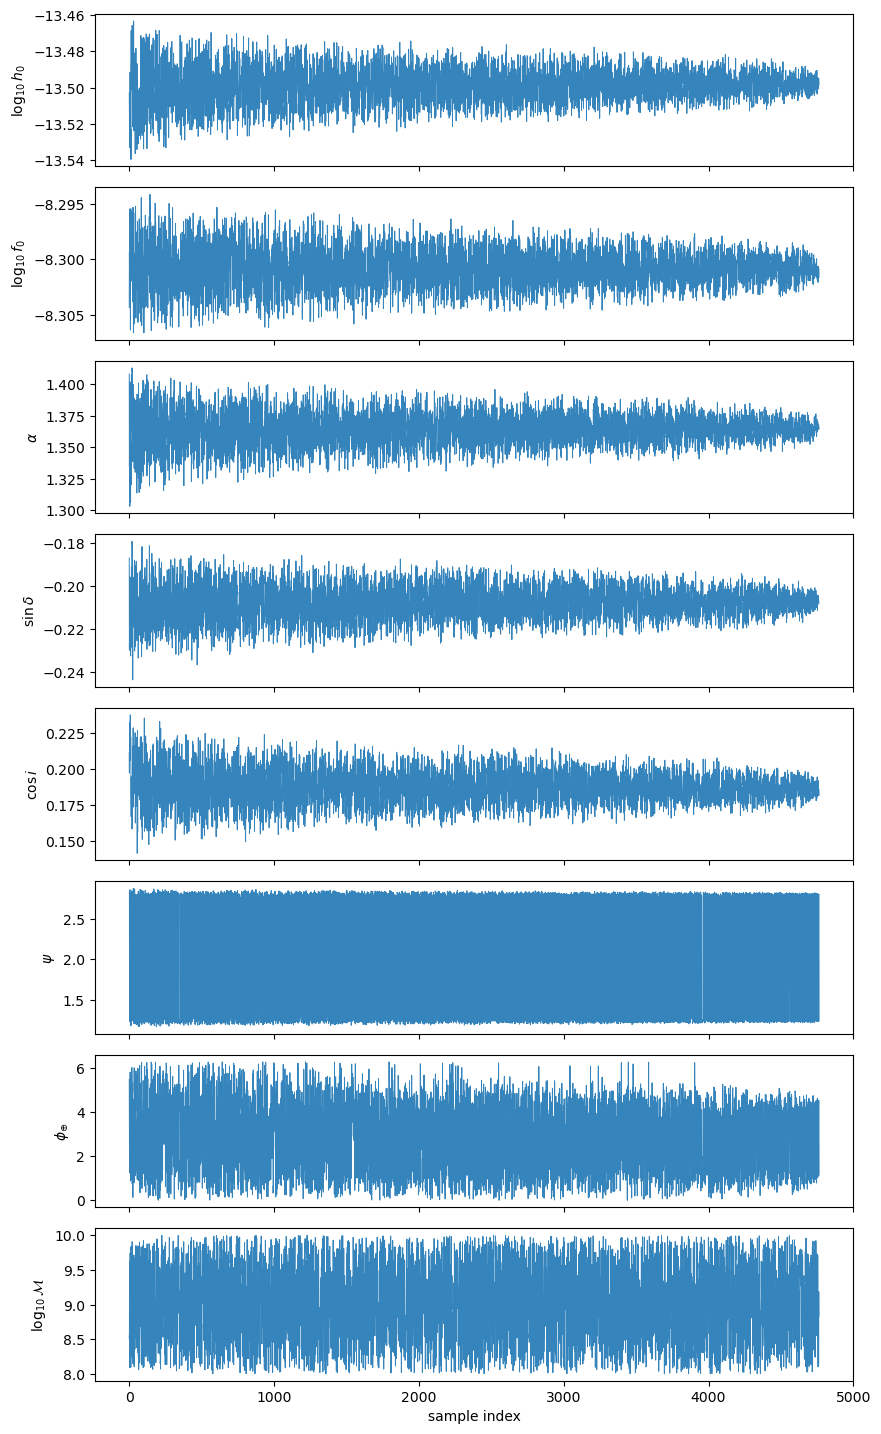

In [25]:
import matplotlib.pyplot as plt
fig = bridge.plot_trace(plot_fixed=True)
plt.show()

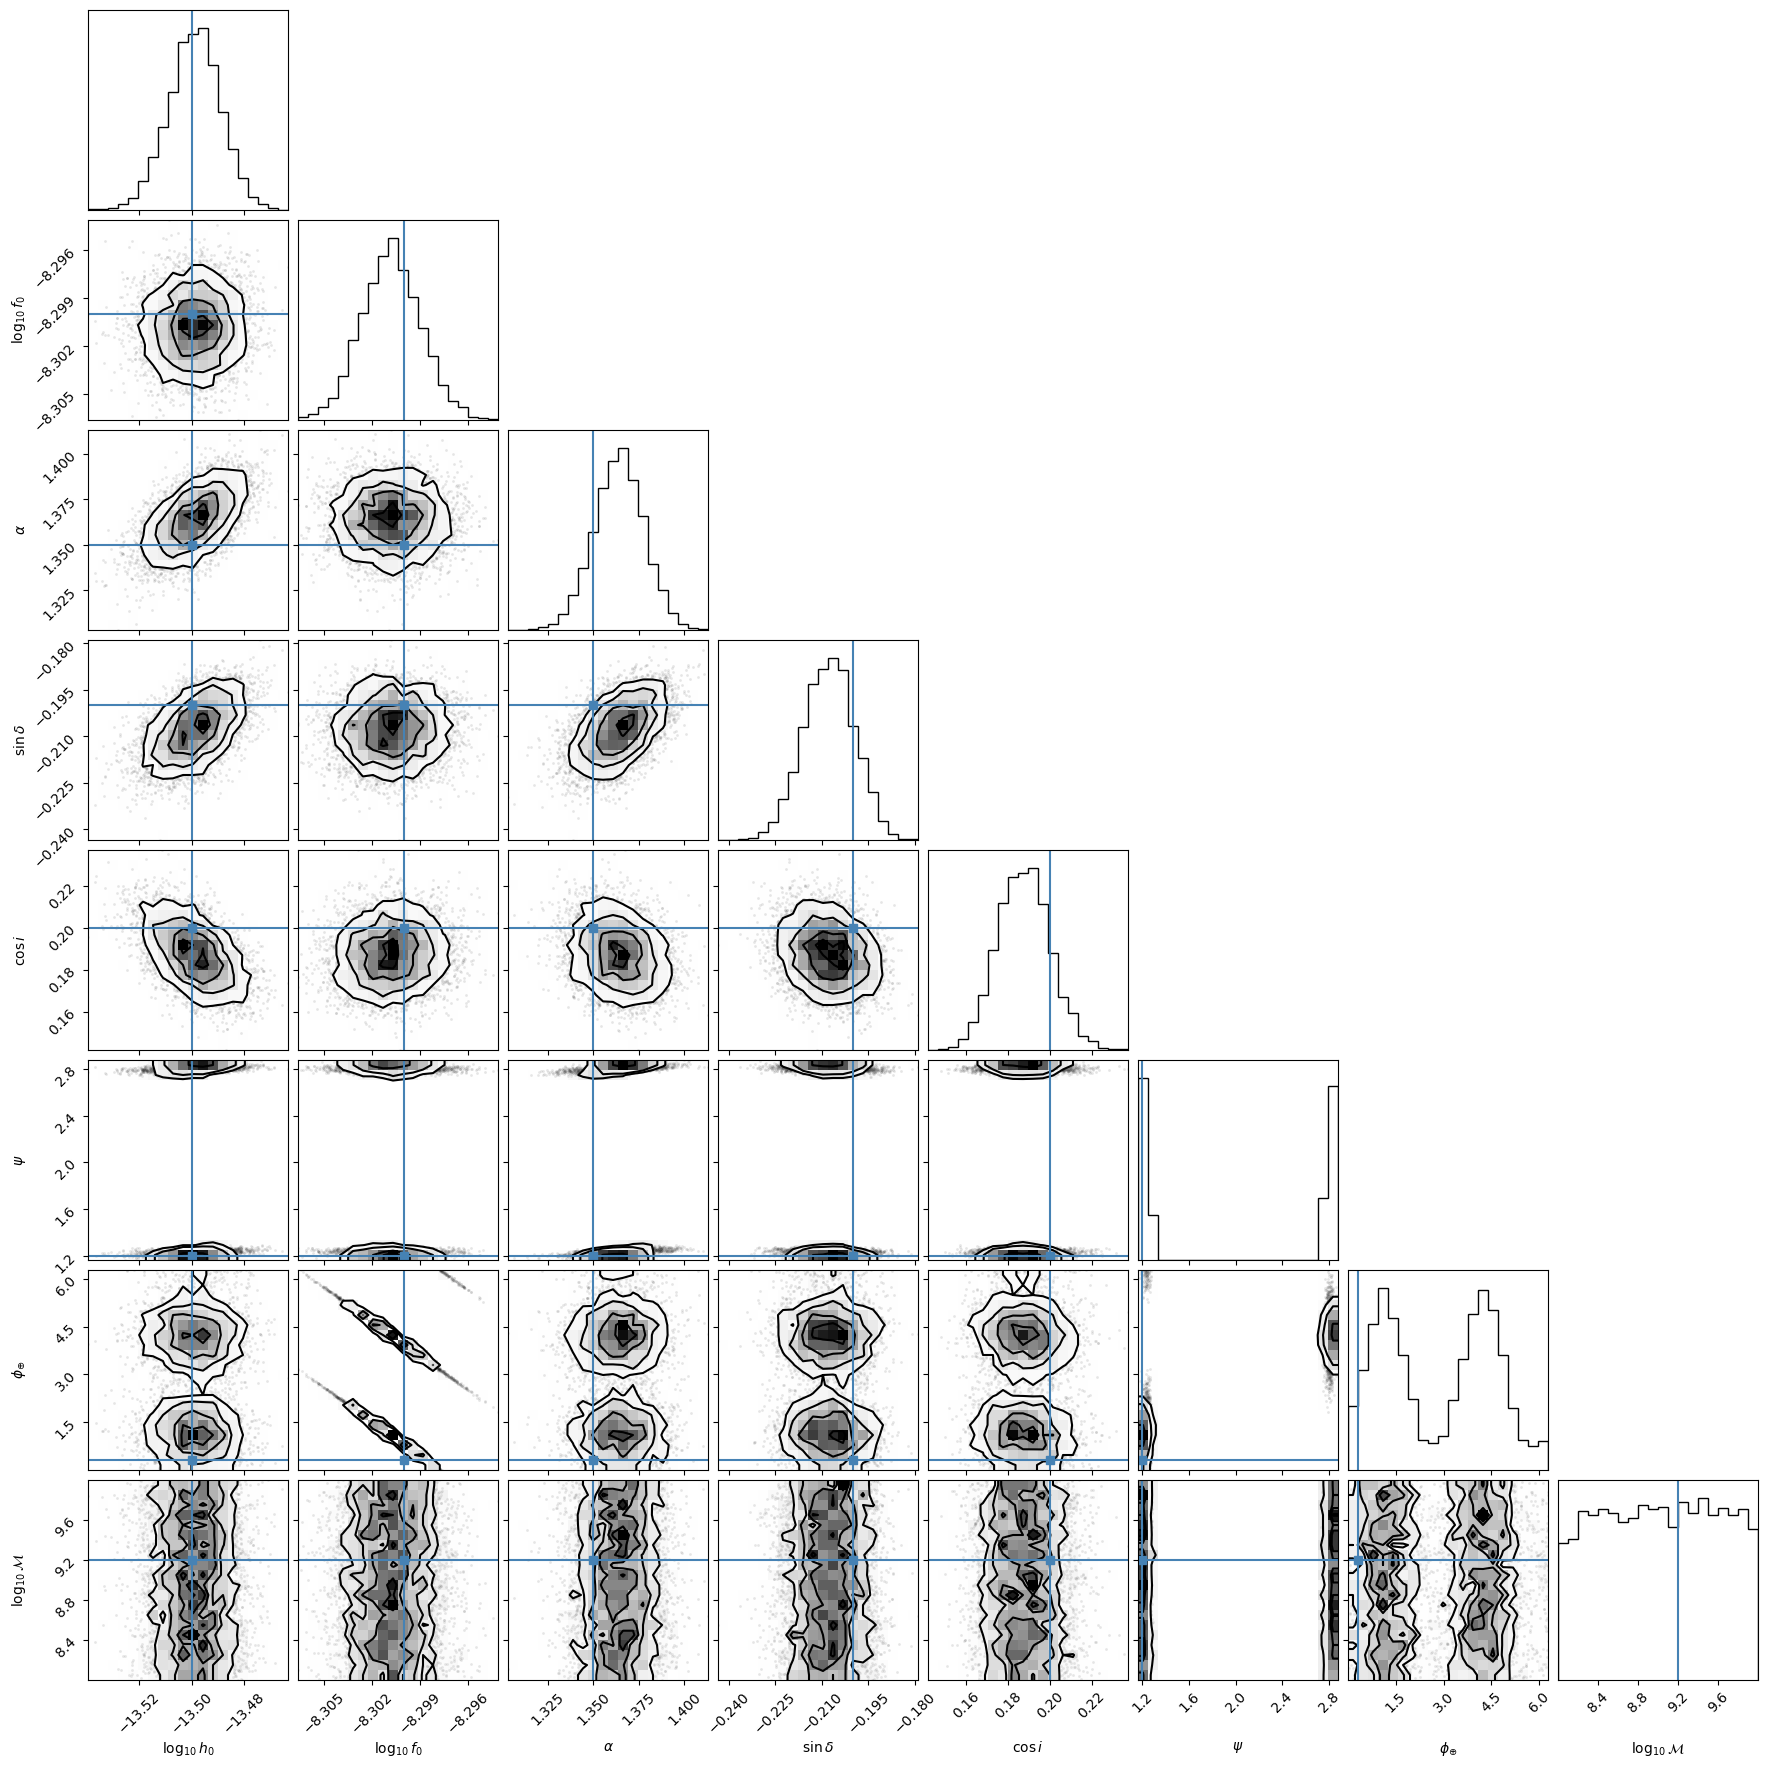

In [30]:
# Corner plot with the true values added

fig2 = bridge.plot_corner(truths=list(injected_values.values()))
plt.show()